In [1]:
import pandas as pd
import numpy as np
import utils
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
import utils 
from utils import generate_submission_file, mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import pandas as pd 
import numpy as np 
import statsmodels.api as sm  # <--- Yay! API! 
%matplotlib inline 
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16, 5)
from statsmodels.tsa.statespace.sarimax import SARIMAX

import itertools

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)   
warnings.filterwarnings("ignore") # specify to ignore warning messages

In [3]:
def get_sarimax_grid():
    p = d = q = P = D = Q = range(0, 2)
    S = 24

    params_combinations = list(itertools.product(p, d, q, P, D, Q))
    inputs = [[x[0], x[1], x[2], x[3], x[4], x[5], S] for x in params_combinations]
    return inputs

In [4]:
def get_mae(series_, params, prediction_window):
    p = params[0] 
    d = params[1] 
    q = params[2] 
    P = params[3]
    D = params[4] 
    Q = params[5]
    S = params[6]
    
    lenght = len(series_)
    series_train = series_[:-prediction_window]
    series_test = series_[-prediction_window:]
    
    model = sm.tsa.statespace.SARIMAX(series_train,
                                      order=(p, d, q),
                                      seasonal_order=(P, D, Q, S),
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)

    results = model.fit(maxiter=500)
    predictions = results.get_forecast(steps=prediction_window)
    predicted_mean_logged = predictions.predicted_mean
    predicted_mean = predicted_mean_logged
    
    return mean_absolute_error(series_test,predicted_mean)

In [5]:
data = pd.read_csv('data/data.csv')

In [6]:
data['date'] = pd.to_datetime(data['date'])

In [7]:
data = data.set_index('date')
data = data.sort_index()

In [8]:
area_1_raw = data[data.variable == 'area_1'].drop('variable', axis = 1).sort_index()
area_2_raw = data[data.variable == 'area_2'].drop('variable', axis = 1).sort_index()
area_3_raw = data[data.variable == 'area_3'].drop('variable', axis = 1).sort_index()

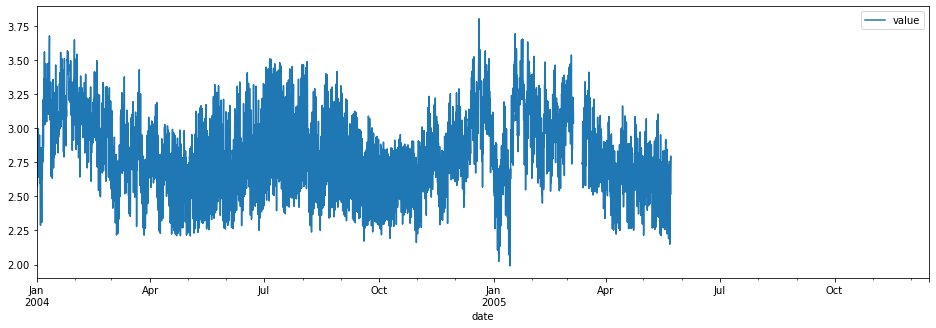

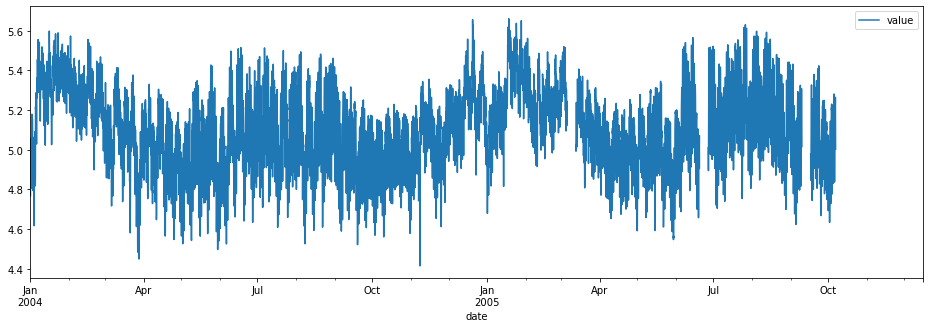

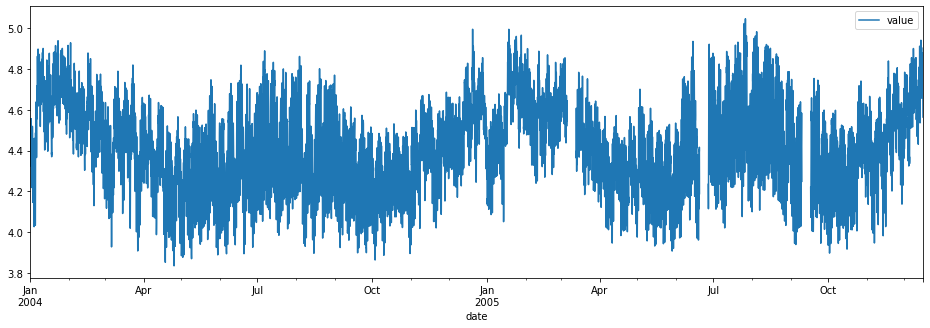

In [9]:
np.log(area_1_raw).plot()
np.log(area_2_raw).plot()
np.log(area_3_raw).plot()

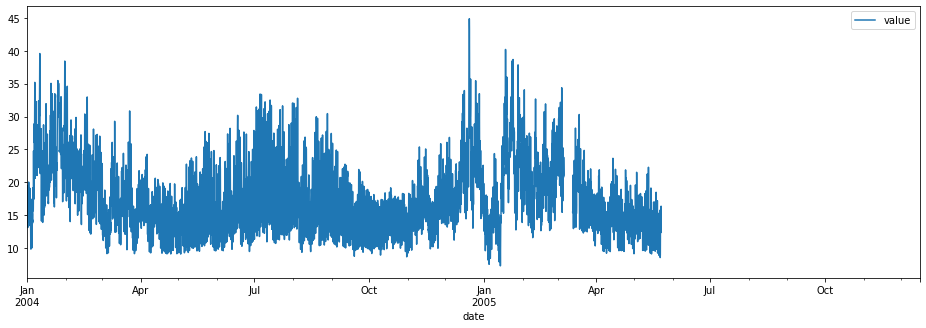

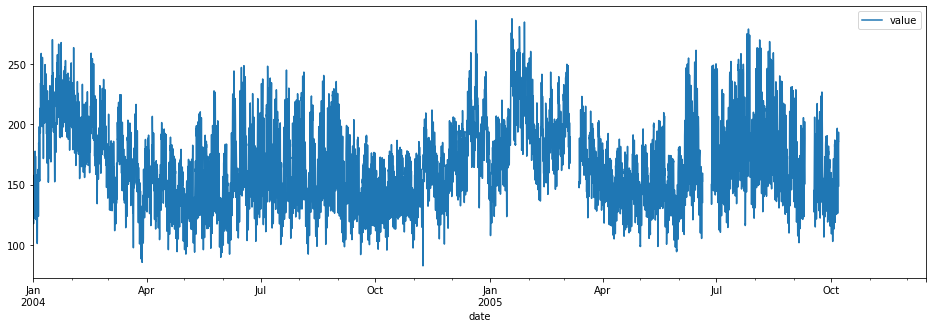

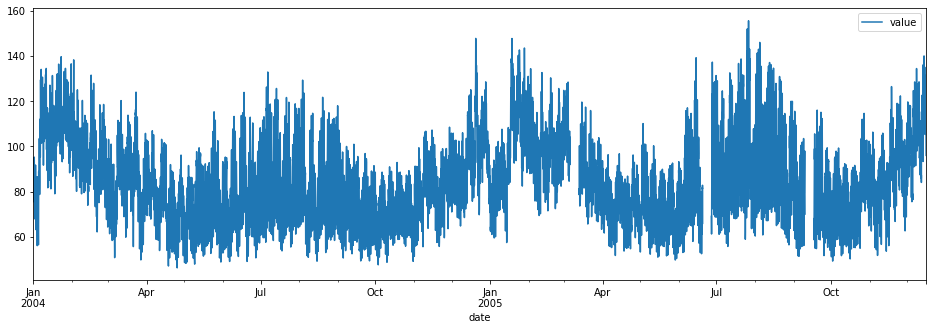

In [10]:
area_1_raw.plot()
area_2_raw.plot()
area_3_raw.plot()

plt.rcParams['figure.figsize'] = (6, 4)

In [11]:
area_1_ = area_1_raw.dropna()
area_2_ = area_2_raw.dropna()
area_3_ = area_3_raw.dropna()

In [12]:
area_1 = area_1_.resample("h").mean().sort_index()
area_2 = area_2_.resample("h").mean().sort_index()
area_3 = area_3_.resample("h").mean().sort_index()

In [13]:
area_1 = (area_1.ffill()+ area_1.bfill())/2
area_2 = (area_2.ffill()+ area_2.bfill())/2
area_3 = (area_3.ffill()+ area_3.bfill())/2

In [14]:
train_1 = area_1[:-168]
train_2 = area_2[:-168]
train_3 = area_3[:-168]

test_1 = area_1[-168:]
test_2 = area_2[-168:]
test_3 = area_3[-168:]

## Grid Search

inputs = get_sarimax_grid()

prediction_window = len(test_3)

mae_scores = {}
params_index = {}

p = d = q = P = D = Q = range(0, 2)   
S = [24]
params_combinations = list(itertools.product(p, d, q, P, D, Q, S))
inputs = [[x[0], x[1], x[2], x[3], x[4], x[5], x[6]] for x in params_combinations]

for i in range(len(inputs)):
    param_set = inputs[i]
    mae = get_mae(train_3, param_set, prediction_window) 
    mae_scores[i] = mae
    params_index[i] = param_set

temp = pd.DataFrame(params_index).T
temp.columns = ['p', 'd', 'q', 'P', 'D', 'Q', 'S']
temp['mae'] = pd.Series(mae_scores)
temp.sort_values('mae').head()

In [17]:
best_model_params = temp.mae.idxmin()
best_params_multistep = temp.loc[best_model_params].astype("int").drop("mae")
best_params_multistep

NameError: name 'temp' is not defined

order=(p, d, q)
seasonal_order=(P, D, Q, S)

In [ ]:
#Area 1
mae_1 = sm.tsa.statespace.SARIMAX(train_1,
                                  order=(1, 0, 0),
                                  seasonal_order=(0, 1, 0, 24))

results_1 = mae_1.fit()
predictions_mae_model_1 = results_1.get_forecast(steps=168)
predicted_mean_1 = predictions_mae_model_1.predicted_mean
mape_1 = mean_absolute_percentage_error(test_1, predicted_mean_1)
mape_1

In [ ]:
#Area 2
mae_2 = sm.tsa.statespace.SARIMAX(train_2,
                                  order=(1, 0, 1),
                                  seasonal_order=(1, 0, 1, 24))

results_2 = mae_2.fit()
predictions_mae_model_2 = results_2.get_forecast(steps=168)
predicted_mean_2 = predictions_mae_model_2.predicted_mean
mape_2 = mean_absolute_percentage_error(test_2, predicted_mean_2)
mape_2 

In [ ]:
#Area 3
mae_3 = sm.tsa.statespace.SARIMAX(train_3,
                                  order=(0, 0, 1),
                                  seasonal_order=(0, 1, 0, 24))

results_3 = mae_3.fit()
predictions_mae_model_3 = results_3.get_forecast(steps=168)
predicted_mean_3 = predictions_mae_model_3.predicted_mean
mape_3 = mean_absolute_percentage_error(test_3, predicted_mean_3)
mape_3

In [ ]:
print(mape_1)
print(mape_2)
print(mape_3)

In [ ]:
mae_1 = sm.tsa.statespace.SARIMAX(area_1,
                                  order=(1, 0, 0),
                                  seasonal_order=(0, 1, 0, 24))

results_1 = mae_1.fit()
predictions_mae_model_1 = results_1.get_forecast(steps=168)
predicted_mean_1 = predictions_mae_model_1.predicted_mean

In [ ]:
mae_1 = sm.tsa.statespace.SARIMAX(area_2,
                                  order=(1, 0, 0),
                                  seasonal_order=(0, 1, 0, 24))

results_1 = mae_1.fit()
predictions_mae_model_1 = results_1.get_forecast(steps=168)
predicted_mean_1 = predictions_mae_model_1.predicted_mean

In [22]:
mae_1 = sm.tsa.statespace.SARIMAX(area_3,
                                  order=(1, 0, 0),
                                  seasonal_order=(0, 1, 0, 24))

results_1 = mae_1.fit()
predictions_mae_model_1 = results_1.get_forecast(steps=168)
predicted_mean_1 = predictions_mae_model_1.predicted_mean

In [23]:
generate_submission_file(predicted_mean_1.values, predicted_mean_2.values, predicted_mean_3.values)

NameError: name 'predicted_mean_2' is not defined